# **Preprocessing of Debagree Data**

## **Package Imports**

In [1]:
!pip install nltk

In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
import matplotlib.pyplot as plt


## **Set file paths**

In [3]:
# debagree data
input_path = "../data/new_preprocessing/debagree_new_preprocessing_com_rep.csv"

# nltk path
nltk_data_path = 'nltk_data'

# output
csv_output_path = "preprocess_outputs/tokens_debagree.csv"
txt_output_path = 'preprocess_outputs/tokens_debagree.txt'
json_output_path = 'preprocess_outputs/tokens_debagree.json'

full_output_path = 'preprocess_outputs/debagree_full.csv'

In [4]:
# import training data
training_data = pd.read_csv(input_path)
training_data

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...",Forensic Audit We conclude that the Dominion V...,Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics its wrong this m...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42809,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333
42810,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333
42811,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333
42812,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a 1200 package until the GOP k...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for 2000 in direct checks, ...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333


## **Preprocessing**

1. Download stop words to remove
2. Data Cleaning
    * base text cleaning is done prior to classification, EMI input data file is created later
    * here, just collapse punctuation etc. (which was still helpful for LLM, but not for EMI)

In [5]:
# Download stop words

nltk.data.path.append(nltk_data_path) # set path
nltk.download('stopwords', download_dir=nltk_data_path) # download to path

stop_words = set(stopwords.words('english'))

# check
#stop_words

[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Preprocessing function

def preprocess(text):
    
    text = text.lower()
    
    # collapse repeated punctuation and letters
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'\!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)
    text = re.sub(r'(\w)\1{2,}', r'\1', text)


    # ensure that punctuation is properly separated from words
    text = re.sub(r"([.,!?()\"*:\\/><“”‘’'_~{}\-^@#])", r' \1 ', text)
    text = re.sub(r"(?<!\w)'(\w+\s*)'(?!\w)", r' \1 ', text) # quotation marks around words remove, thers not
    text = re.sub(r'(\])', r' \1 ', text)
    text = re.sub(r'(\[)', r' \1 ', text)

    text = re.sub(r'\d+', ' ', text).strip() # remove any numbers
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenize and remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # manual cleaning from investigation
    to_remove = ["?", "!", ",", ".", "'", "*", "/", "\"", "\\", "[", "]", "(", ")", ":", ">", "<", "“", "”", 
                 "–", "-", "‘", "’", "+", "|", "~", "_", "{", "}", "^", "%", "$", "@", "#"]
    words = [word for word in words if word not in to_remove]
    
    words = " ".join(words)
    
    return words


## **Preprocess Data Frame**

In [7]:
# apply preprocess
training_data['parent_tokens'] = training_data['body_parent'].apply(preprocess)
training_data['child_tokens'] = training_data['body_child'].apply(preprocess)
training_data['submission_tokens'] = training_data['submission_text'].apply(preprocess)

# determine nr. of words
training_data['parent_len'] = training_data['parent_tokens'].apply(lambda x: len(x.split()))
training_data['child_len'] = training_data['child_tokens'].apply(lambda x: len(x.split()))
training_data['submission_len'] = training_data['submission_tokens'].apply(lambda x: len(x.split()))

#### Remove empty texts

In [8]:
# find interactions, where one text got empty, remove reffering interaction as a whole

filtered_df = training_data[
    (training_data[["child_len", "parent_len", "submission_len"]] == 0).any(axis=1)
]

filtered_df

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa,parent_tokens,child_tokens,submission_tokens,parent_len,child_len,submission_len
15527,1,cseqb9d,csex4l0,3aor2c,300 to 400 ppm is a 33 increase--I don't know ...,400 - 300 100 100 300 0.33 0.33 100 33,"Open, Sincere Question about the math not a cl...",climate,dpitch40,1434992409,Fungus_Schmungus,22/06/2015 17:00,0.666667,0.333333,ppm increase know exact math behind imagine mi...,,open sincere question math climate change deni...,17,0,51


In [9]:
# drop 

print("OG length", len(training_data))

training_data = training_data.drop(filtered_df.index).reset_index(drop = True)

print("Afterwards length", len(training_data))

OG length 42814
Afterwards length 42813


In [10]:
training_data

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa,parent_tokens,child_tokens,submission_tokens,parent_len,child_len,submission_len
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...",Forensic Audit We conclude that the Dominion V...,Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000,elected biden faith election process especiall...,contested election media lying ignore set,forensic audit conclude dominion voting system...,14,6,17
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000,tlaib family hamas funded iran state sponsor t...,truthful swore oath office serve constituents ...,biden squad tlaib stage heated confrontation t...,29,13,8
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000,republicans happy biden bring country together...,happy going rioting move daily life lol,president elect biden projected win pennsylvan...,8,7,10
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics its wrong this m...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333,going happen trend police risk getting charged...,fire use weapon unless absolutely necessary wa...,even issue politics wrong man charged,51,13,6
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000,gotta start normalizing defending women screw ...,nah women equal rights days treat want fight m...,young man wearing maga hat attacked school spi...,18,15,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42808,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333,fundamentally trump simply work potus lacks in...,believe pence would improvement trump winning ...,ezra klein twitter donald trump want charge wa...,41,18,22
42809,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333,hope usa finds vaccine first put eurofags demo...,given good nature intentions vaccine researche...,president trump promised fast vaccine fastest ...,9,20,14
42810,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333,postcard mailing project general election,search mobilize us wasnt able find postcard op...,volunteer home help flip senate details comments,5,8,7
42811,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a 1200 package until the GOP k...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for 2000 in direct checks, ...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333,comical package gop killed look like fools tru...,never forget billion includes almost half orig...,nancy pel

## **Make Training Texts**

In [12]:
# finde unique comments, replies and submissions

parent = training_data[['msg_id_parent', 'parent_tokens']].drop_duplicates(subset = 'msg_id_parent')
child = training_data[['msg_id_child', 'child_tokens']].drop_duplicates(subset = 'msg_id_child')
submission = training_data[['submission_id', 'submission_tokens']].drop_duplicates(subset = 'submission_id')

training_texts = pd.DataFrame(pd.concat([parent['parent_tokens'], child['child_tokens'], submission['submission_tokens']]), columns = ['text']).reset_index(drop = True)
print(len(training_texts))


93334


**Decision** 

It can happen, that the exact same text is used, once as a comment and once as a reply, for example.

* Therefore, I have 93.334 unique texts, when filtering on text_id's.
* But when applying `drop_duplicates`, I end up with 93.220

* For my analysis of comment and reply interactions, the id's are chosen as the unique identifier.

***

In [14]:
# check
training_texts_cleaned = training_texts.copy(deep = True)

training_texts_cleaned['text']#[10]

0        elected biden faith election process especiall...
1        tlaib family hamas funded iran state sponsor t...
2        republicans happy biden bring country together...
3        going happen trend police risk getting charged...
4        gotta start normalizing defending women screw ...
                               ...                        
93329    fining taking part misinformation assisted ove...
93330    believe white privilege privileges white peopl...
93331    brexit evidence weve conned keeps piling globa...
93332    brexit deal panic eu lose one million jobs bil...
93333    uk brexit proposal removes irish backstop says...
Name: text, Length: 93334, dtype: object

#### **Check lengths of texts**

* Some texts are now < 5 words
    * However, that threshold was to give the LLM context, to classify disagreement
    * For EMI score, texts could be shorter (doing double check in Meeting with Peer and Segun)  

In [15]:
training_texts_cleaned['len'] = training_texts_cleaned['text'].apply(lambda t: len(t.split()))

pd.DataFrame(training_texts_cleaned['len'].value_counts().reset_index()).sort_values('len')

,len,count
65,1,5
55,2,44
44,3,328
23,4,1224
11,5,2843
...,...,...
72,70,1
68,71,3
71,72,2
73,73,1


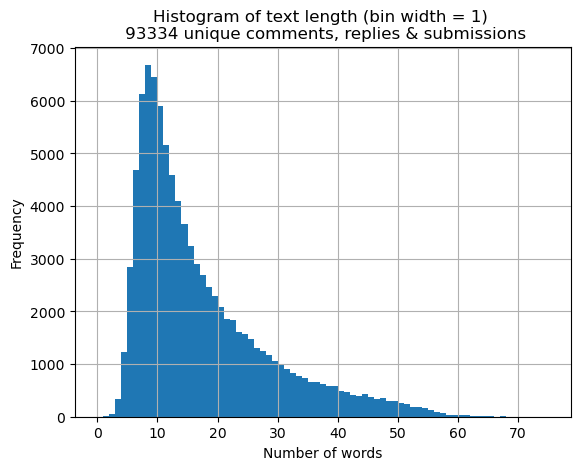

In [16]:
training_texts_cleaned = training_texts_cleaned[training_texts_cleaned['len'] > 0]

bin_edges = np.arange(0, training_texts_cleaned['len'].max() + 1, 1)
training_texts_cleaned['len'].hist(bins=bin_edges)

plt.title(f"Histogram of text length (bin width = 1) \n {len(training_texts_cleaned)} unique comments, replies & submissions")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.grid(True)

plt.show()

In [17]:
print("Mean:", training_texts_cleaned['len'].mean())
print("Median:", training_texts_cleaned['len'].quantile(0.5))


Mean: 16.86097242162556
Median: 13.0


In [18]:
# check punctuation

for tokens in training_texts_cleaned['text'].sample(5):  # Check random 5 rows
    print(tokens)

impeachment defense flashback kamala harris laughing killing trump pence
yes yes drags pump green economy new green deal build back convince people shut
unfortunately think move voting virtual proceed timeline planned
even chips boiled potatoes lot uk vegetable oil imported
love stop paying welfare states tax dollars threaten good time


## **Save to outputs**

In [19]:
training_texts_cleaned[training_texts_cleaned['text'] != ""]

,text,len
0,elected biden faith election process especiall...,14
1,tlaib family hamas funded iran state sponsor t...,29
2,republicans happy biden bring country together...,8
3,going happen trend police risk getting charged...,51
4,gotta start normalizing defending women screw ...,18
...,...,...
93329,fining taking part misinformation assisted ove...,38
93330,believe white privilege privileges white peopl...,11
93331,brexit evidence weve conned keeps piling globa...,8
93332,brexit deal panic eu lose one million jobs bil...,14


In [20]:
# drop empty strings

training_texts_cleaned = training_texts_cleaned[training_texts_cleaned['text'] != ""] # drop empty strings

In [21]:
# to csv
training_texts_cleaned.to_csv(csv_output_path, index = False)

# to json file
training_texts_cleaned.to_json(json_output_path, orient='records', lines=True)

# to txt
with open(txt_output_path, 'w', encoding='utf-8') as f:
    for sentence in training_texts_cleaned['text']:
        f.write(sentence + "\n")

## **Descriptive Stats on Text length**

$\to$ watch out, now modifying the debagree data again. Comments and Submissions will be duplicated 

In [23]:
parents = training_data[['msg_id_parent', 'parent_len']].drop_duplicates(subset = "msg_id_parent")
child = training_data[['msg_id_child', 'child_len']].drop_duplicates(subset = "msg_id_child")
submissions = training_data[['submission_id', 'submission_len']].drop_duplicates(subset = "submission_id")


len(parents) + len(submissions) +len(child)

93334

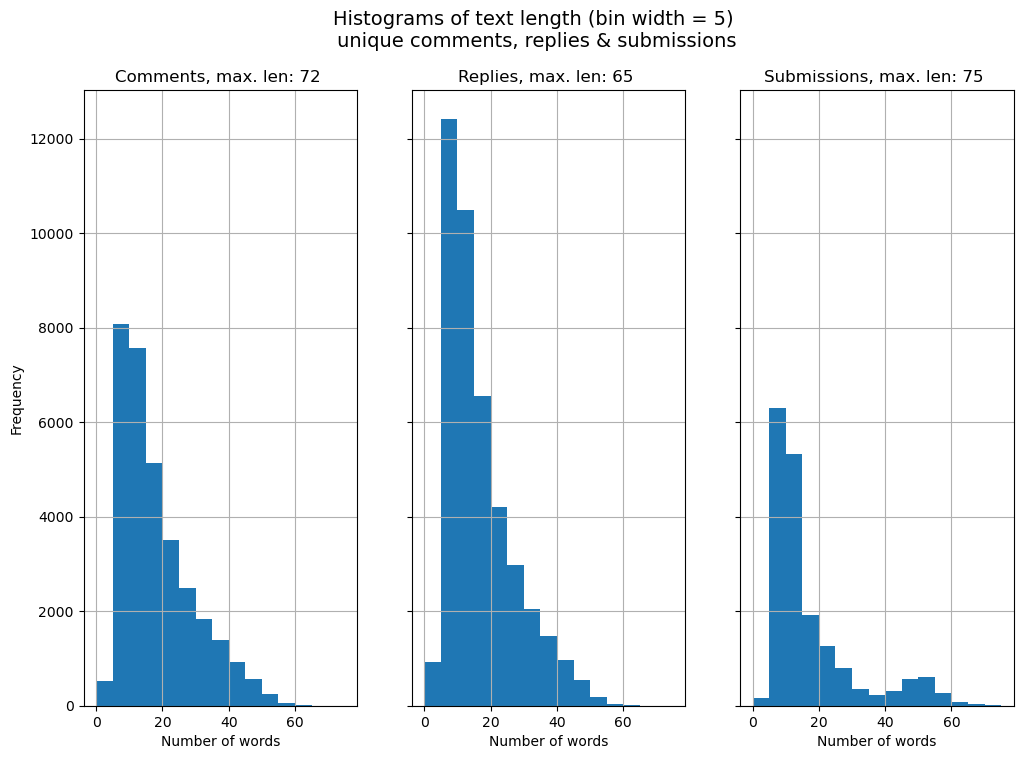

In [24]:

bin_edges = np.arange(0, max(parents['parent_len'].max(), 
                              child['child_len'].max(), 
                              submissions['submission_len'].max()) + 5, 5)

fig, axes = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
fig.suptitle(f"Histograms of text length (bin width = 5)\n unique comments, replies & submissions", fontsize=14)

axes[0].hist(parents['parent_len'], bins=bin_edges)
axes[0].set_title(f"Comments, max. len: {parents['parent_len'].max()} ")
axes[0].set_xlabel("Number of words")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

axes[1].hist(child['child_len'], bins=bin_edges)
axes[1].set_title(f"Replies, max. len: {child['child_len'].max()} ")
axes[1].set_xlabel("Number of words")
axes[1].grid(True)

axes[2].hist(submissions['submission_len'], bins=bin_edges)
axes[2].set_title(f"Submissions, max. len: {submissions['submission_len'].max()} ")
axes[2].set_xlabel("Number of words")
axes[2].grid(True)

plt.show()

In [25]:
training_data

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa,parent_tokens,child_tokens,submission_tokens,parent_len,child_len,submission_len
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...",Forensic Audit We conclude that the Dominion V...,Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000,elected biden faith election process especiall...,contested election media lying ignore set,forensic audit conclude dominion voting system...,14,6,17
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000,tlaib family hamas funded iran state sponsor t...,truthful swore oath office serve constituents ...,biden squad tlaib stage heated confrontation t...,29,13,8
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000,republicans happy biden bring country together...,happy going rioting move daily life lol,president elect biden projected win pennsylvan...,8,7,10
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics its wrong this m...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333,going happen trend police risk getting charged...,fire use weapon unless absolutely necessary wa...,even issue politics wrong man charged,51,13,6
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000,gotta start normalizing defending women screw ...,nah women equal rights days treat want fight m...,young man wearing maga hat attacked school spi...,18,15,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42808,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333,fundamentally trump simply work potus lacks in...,believe pence would improvement trump winning ...,ezra klein twitter donald trump want charge wa...,41,18,22
42809,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333,hope usa finds vaccine first put eurofags demo...,given good nature intentions vaccine researche...,president trump promised fast vaccine fastest ...,9,20,14
42810,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333,postcard mailing project general election,search mobilize us wasnt able find postcard op...,volunteer home help flip senate details comments,5,8,7
42811,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a 1200 package until the GOP k...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for 2000 in direct checks, ...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333,comical package gop killed look like fools tru...,never forget billion includes almost half orig...,nancy pel

In [26]:
training_data.to_csv(full_output_path, index = False)

## **Some checking of duplicated texts**

In [16]:
#training_data = pd.read_csv(input_path)
training_data

,label,msg_id_parent,msg_id_child,submission_id,body_parent,body_child,submission_text,subreddit,author_parent,exact_time,author_child,datetime,agreement_fraction,individual_kappa
0,0,gfvmv5x,gfvmzei,kd0se4,So now that they have elected Biden how can we...,"They haven't, it is a contested election. The ...",Forensic Audit We conclude that the Dominion V...,Republican,guildarts15,1607998349,03-Oct,15/12/2020 02:12,1.000000,1.000000
1,2,gyn3we6,gyn4ruu,nfrunb,"Tlaib, your family is Hamas. Funded by Iran a ...",She was not truthful when she swore her oath o...,Biden and The Squad's Tlaib stage heated confr...,Republican,oppositeofoutside,1621387168,cmcolfax,19/05/2021 01:19,1.000000,1.000000
2,0,gbh1w5x,gbh2dxt,jpv1jr,Most Republicans are happy with Biden as he wi...,I'm not happy about it but I'm not going out a...,President-elect Biden is projected to win Penn...,Republican,Rpdaca,1604773521,elang7390,07/11/2020 18:25,1.000000,1.000000
3,0,fv8hp2o,fv9lbzd,hbf73b,What is going to happen with this trend is tha...,Shouldn't they only fire use their weapon unle...,Not even an issue of politics its wrong this m...,Republican,wiseways9999,1592511116,Hotelier83,18/06/2020 20:11,0.666667,0.333333
4,0,g8ahfgp,g8ahzwk,j8crnu,We gotta start normalizing defending ourselves...,Nah women are about equal rights now a days so...,Young man wearing MAGA hat attacked at school ...,Republican,jwymes44,1602308654,notaglock,10/10/2020 05:44,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42809,2,fpqh5kk,fpshofn,gez26f,"More fundamentally, Trump simply can't do the ...",Do you believe Pence would be an improvement? ...,Ezra Klein on Twitter--Donald Trump does not w...,democrats,p011t1c5,1588873646,Onearmplanche,07/05/2020 17:47,0.666667,0.333333
42810,1,fkqjayp,fkw48q9,fjvy9f,I hope USA finds the vaccine first. That shoul...,Given the good nature and intentions of vaccin...,"President Trump promised a fast vaccine, this ...",Republican,No555M,1584583111,superdmp,19/03/2020 01:58,0.666667,0.333333
42811,0,gbohwgc,gbou2hb,jqok2a,Is there a postcard mailing project? I did tha...,I did a search on Mobilize.us but i wasnt able...,Volunteer from home to help flip the senate. D...,democrats,wagonwheelwhat,1604896314,princesspeach722,09/11/2020 04:31,0.666667,0.333333
42812,1,ggrfp0s,ggrhkvu,kijy95,Comical. We had a 1200 package until the GOP k...,Never forget this 900 billion includes almost ...,"Nancy Pelosi calls for 2000 in direct checks, ...",democrats,kmurph72,1608694630,sulkee,23/12/2020 03:37,0.666667,0.333333


In [17]:
parents = training_data[['body_parent', 'subreddit']].rename(columns = {"body_parent" : 'text'})
parents['type'] = 'parent'
parents = parents.drop_duplicates().reset_index(drop = True) #32352 unique messages (checked with msg_id_parent)
parents
#parents['msg_id_parent'].drop_duplicates()

,text,subreddit,type
0,So now that they have elected Biden how can we...,Republican,parent
1,"Tlaib, your family is Hamas. Funded by Iran a ...",Republican,parent
2,Most Republicans are happy with Biden as he wi...,Republican,parent
3,What is going to happen with this trend is tha...,Republican,parent
4,We gotta start normalizing defending ourselves...,Republican,parent
...,...,...,...
32279,The only research required is to survey all th...,Brexit,parent
32280,Jesus Christ!. The US has invaded countries fo...,Brexit,parent
32281,the Northern Ireland assembly and executive wo...,Brexit,parent
32282,I hope USA finds the vaccine first. That shoul...,Republican,parent


In [18]:
children = training_data[['body_child', 'subreddit']].rename(columns = {"body_child" : 'text'})
children['type'] = 'child'

# there are duplicated texts with the same content (but different msg_id_child) 
# partly: removed posts or comments i.e. due to community guidelines
# partly: doubled text
# --> will remove

#duplicated = children[children.duplicated('text', keep=False) == True]
#duplicated.reset_index(drop = True, inplace = True)
#print(duplicated.iloc[4])
#print(duplicated.iloc[115])

children = children.drop_duplicates(subset = "text").reset_index(drop = True)
children

,text,subreddit,type
0,"They haven't, it is a contested election. The ...",Republican,child
1,She was not truthful when she swore her oath o...,Republican,child
2,I'm not happy about it but I'm not going out a...,Republican,child
3,Shouldn't they only fire use their weapon unle...,Republican,child
4,Nah women are about equal rights now a days so...,Republican,child
...,...,...,...
42796,Do you believe Pence would be an improvement? ...,democrats,child
42797,Given the good nature and intentions of vaccin...,Republican,child
42798,I did a search on Mobilize.us but i wasnt able...,democrats,child
42799,Never forget this 900 billion includes almost ...,democrats,child


In [19]:
submissions = training_data[['submission_text', 'subreddit']].rename(columns = {"submission_text" : 'text'})
submissions['type'] = 'submission'
submissions = submissions.drop_duplicates().reset_index(drop = True)
submissions

# submissions['submission_id'].drop_duplicates() # --> also leads to 18206 unique

,text,subreddit,type
0,Forensic Audit We conclude that the Dominion V...,Republican,submission
1,Biden and The Squad's Tlaib stage heated confr...,Republican,submission
2,President-elect Biden is projected to win Penn...,Republican,submission
3,Not even an issue of politics its wrong this m...,Republican,submission
4,Young man wearing MAGA hat attacked at school ...,Republican,submission
...,...,...,...
18146,Fining those taking part in the misinformation...,democrats,submission
18147,If you believe in white privilege what are som...,democrats,submission
18148,Brexit The Evidence that Weve All Been Conned...,Brexit,submission
18149,Brexit no deal panic EU to lose one million jo...,Brexit,submission


In [20]:
training_data_w_subreddit = pd.concat([parents, children, submissions])
training_data_w_subreddit.reset_index(drop = True, inplace = True)
training_data_w_subreddit

,text,subreddit,type
0,So now that they have elected Biden how can we...,Republican,parent
1,"Tlaib, your family is Hamas. Funded by Iran a ...",Republican,parent
2,Most Republicans are happy with Biden as he wi...,Republican,parent
3,What is going to happen with this trend is tha...,Republican,parent
4,We gotta start normalizing defending ourselves...,Republican,parent
...,...,...,...
93231,Fining those taking part in the misinformation...,democrats,submission
93232,If you believe in white privilege what are som...,democrats,submission
93233,Brexit The Evidence that Weve All Been Conned...,Brexit,submission
93234,Brexit no deal panic EU to lose one million jo...,Brexit,submission


In [21]:
# sometimes, same comment as parent or child

duplicated = training_data_w_subreddit[training_data_w_subreddit.duplicated('text', keep=False) == True]
duplicated.reset_index(drop = True, inplace = True)
duplicated

,text,subreddit,type
0,Did you ever ask yourself why these idiot repu...,climate,parent
1,No different to usual then. At least after the...,Brexit,parent
2,"Feb 23, 2016 2021 Priti Patel, Britain's minis...",Brexit,parent
3,Suggest this statement is one of the most prof...,democrats,parent
4,EU not Europe. She pokes her head from behind ...,Brexit,parent
5,You know we're never ever ever ever ever ever ...,Republican,parent
6,"Boris we love you and stand by you, your doing...",Brexit,parent
7,We all need to get to work. I have already par...,democrats,parent
8,It also wouldn't surprise me if a large minori...,Brexit,parent
9,EU not Europe. She pokes her head from behind ...,Brexit,child
